# Mobile Robotics : Group T25 Report Project


## Table of Contents


* [1. Introduction](#introduction)
<br/><br/>
* [2. Computer Vision](#cv)
    * [2.1. Introduction to Yolov8](#yolov8)
    * [2.2. Application on the Thymio](#application_yolo)
        * [2.2.1. Images of System Detection](#cv_images) 
    * [2.3. Detection function](#detection_function)
      * [2.3.1. Packages required](#CV_packages)
      * [2.3.2. Function explanation](#CV_explanation)   
    * [2.4. Annotation function](#annotation) 
<br/><br/>
* [3. Global Path](#global_path)
    * [3.1. Overall Path strategy](#path_strategy)
    * [3.2. Global Path Planning](#global_path_planning)
    * [3.3. Global Path Function](#global_path_function)
        * [3.3.1. Packages required ](#global_path_packages)
        * [3.3.2. Function Explanation ](#global_path_explanation)
        * [3.3.3. Example of global path ](#global_path_example)
        <br/><br/>
* [4. Local Navigation](#local_navigation)
    * [4.1.Local Navigation Function](#local_navigation_function)
    * [4.2 Key parameters](#key_parameters)
<br/><br/>     
* [5. Motion Control](#motion_control)
    * [5.1. Drive function](#drive)
    * [5.2. Turn function](#turn)
<br/><br/>
* [6. Filtering](#filtering)
    * [6.1. Introduction to the Markov Filter](#markov_filter)
    * [6.2. Implementation of the Markov Filter](#application_filter)
        * [6.2.1. Initialisation of the map](#map_initialisation)
        * [6.2.2. State belief](#state_belief)
        * [6.2.3. Sensor update](#sensor_update)
        * [6.2.4. Motion update and Calculation step](#calculation_step)
        * [6.2.5. Heatmap plot](#heatmap)
        * [6.2.6. Markov function](#m_function)
    * [6.3. Limitations of the Markov Filter](#problems)
<br/><br/>  
* [7. Main code](#main_code)
    * [7.1. Packages and Functions importation](#packages_functions_importation)
    * [7.2.Initialize Thymio functions](#Thymio_functions)
    * [7.3.Main loop](#main_loop)
<br/><br/>  
* [8. Videos demonstration](#videos_demonstration)
    * [8.1. Demonstration without kidnapping](#videos_demonstration_without)
    * [8.2. Demonstration with kidnapping](#videos_demonstration_with)
<br/><br/> 
* [9. Conclusion](#conclusion)
<br/><br/>
* [10. References](#references)
    * [10.0. General](#rg_references)
    * [10.1. Computer vision](#cv_references)
    * [10.2. Global path](#gp_references)
    * [10.3. Local Navigation](#ln_references)
    * [10.4. Filtering](#f_references)

## 1. Introduction <a class="anchor" id="introduction"></a>

The aim of this project was to integrate the different themes currently being seen in one project: path planning, vision, local navigation and filtering. To combine these, we treated our robot as a spaceship.

Thymio Mars V aims to reach Mars in the shortest possible time, avoiding black holes along the way. To do this, the camera detects the robot's position, the position of Mars and the position of the black holes. To determine the shortest route, we decided to use the A* algorithm, as it's easy to implement and doesn't require a lot of resources. If Thymio Mars V encounters an asteroid field on its path, obstacle detection takes control and, thanks to the proximity sensors, the robot is able to avoid it.

Finally, Markov Filtering is used to be sure that the robot starts at the right position because this type of filtering is effective when there is uncertainty about the position and speed, which is the case in this project.



## 2. Computer Vision <a class="anchor" id="cv"></a>

### 2.1. Introduction to Yolov8 <a class="anchor" id="yolov8"></a>

YOLOv8 is the newest state-of-the-art YOLO model that can be used for object detection, image classification, and instance segmentation tasks. YOLOv8 was developed by Ultralytics, who also created the influential and industry-defining YOLOv5 model. YOLOv8 includes numerous architectural and developer experience changes and improvements over YOLOv5.

Yolov8 is based on a Convolutional neural network, the main idea is to train a model using this CNN with an adapted dataset.


Convolutional neural network (CNN) is a regularized type of feed-forward neural network that learns feature engineering by itself via filters (or kernel) optimization. Vanishing gradients and exploding gradients, seen during backpropagation in earlier neural networks, are prevented by using regularized weights over fewer connections.For example, for each neuron in the fully-connected layer 10,000 weights would be required for processing an image sized 100 × 100 pixels.

Sources :

https://blog.roboflow.com/whats-new-in-yolov8/

https://en.wikipedia.org/wiki/Convolutional_neural_network


### 2.2. Application of Yolov8 on the thymio <a class="anchor" id="application_yolo"></a>


The basic idea was to use yolov8 to detect the robot, start point and obstacles at any point in time. We first train our model with :
- annotation of a dataset on Robotflow (https://app.roboflow.com/gabriel-paffi)
- training our system on a google colab to accelare our training process (https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb#scrollTo=I4bpUIibcV1l)

Once we have obtained our model trained on our dataset, we can use this model to predict the class, position and confidence of any object of our datasets.

#### 2.2.1 Images of System Detection <a class="anchor" id="cv_images"></a>

<div style="text-align:center">
    <img src="./cv_images/robot.png" alt="System detection objects">
</div>

<div style="text-align:center">
    <img src="./cv_images/System.png" alt="System detection objects">
</div>


### 2.3. Detection function <a class="anchor" id="detection_function"></a>


#### 2.3.1. Packages required <a class="anchor" id="CV_packages"></a>

- open cv2 : https://opencv.org/
- Yolov8 from ultralytics : https://github.com/ultralytics/ultralytics

#### 2.3.2. Explanation of the function <a class="anchor" id="CV_explanation"></a>

This function take into input a frame and return :
- an array containing the different object as follow : (class, x_center, y_center, width_object, height_object)
- a frame annotated with the class object on it and the confidence accord to the object

This function use our train model (robotv12.pt) and a minimum confidence to detect an object of 0.55 (1 is maximum confidence).

In [1]:
import cv2
from ultralytics import YOLO
model = YOLO("robotv12.pt")
class_object = ["blackholes","earth","mars", "robot" ]

def detection(frame):

    confidence_min = 0.55

    results = model.track(frame, conf = confidence_min, verbose = False)

    annotated_frame = results[0].plot()


    array_box_dim_tot = []
           
   

    for objects in results:
    
            number_objects = len(objects.boxes.cls)
            box_dimensions = objects.boxes.xywhn
            for i in range(number_objects) :
              
                array_box_dim_object = []
                confidence = round(objects.boxes.conf[i].item(),3)
                cls = objects.boxes.cls[i].item()
                array_box_dim = box_dimensions[i].tolist() # center x,y width, height
                for i in range(len(array_box_dim)):
                    array_box_dim[i] = round(array_box_dim[i],2)
                array_box_dim_object = [class_object[int(cls)], array_box_dim, confidence]

                array_box_dim_tot.append(array_box_dim_object)


                        

    return(array_box_dim_tot, annotated_frame)

### 2.4. Annotation function <a class="anchor" id="annotation"></a>

This function goal is to add the path of the robot on the frame.
The input of this function are :
- a frame
- coordinates : the coordinates of each point from the robot towards the goal

The output is the frame with segment between each point of the path.



In [2]:
def annotation(frame, coord):
    
    for k in range(len(coord)-1):
        
        frame = cv2.circle(frame, coord[k], circle_radius, blue,circle_thicknes)
        frame = cv2.line(frame, coord[k], coord[k+1], blue, line_thickness)  

    return frame

## 3. Global Path <a class="anchor" id="global_path"></a>




### 3.1. Overall Path Strategy <a class="anchor" id="path_strategy"></a>

Space is a hostile place where a lot of unpredictable things can happen. We therefore wanted a robust system that is resilient to changes in object placements, and changes to camera placement. A system that updates these position at each timestep will be resilient to any changes. However, computing object placements and computing the global path takes time. We therefore chose to move the robot in steps of ~5cm after which we recompute positions and global path. This has the drawback of our robot stopping every ~5cm. The advantage is that any new objects will be detected quickly, and if the goal is moved, the robot will quickly adjust its path. It also has the advantage that kidnapping is very easy to sort out.

If we do not get any input from the camera, we rely on the last calculated global path and the position and angle estimated by the robot itself. 

The angle of the robot is calculated by both the camera and the robot. For each step the robot turns a certain amount and from this it knows its angle. The camera can also calculate the angle of the tracetory of the robot when looking at two timesteps, and from this calculate the angle. The angle used by the system is the average of these two calculated angles. 

### 3.2. Global Path Planning <a class="anchor" id="global_path_planning"></a>

To succesfully navigate an environment a path needs to be computed. For our 'space' environment we wanted a path close to the optimal path and a efficient computation. Visibility graphs are very efficient and can find the optimal path. However, with round planets this does not work because of the missing edges. While the planets could be approximated with polygons to be used with the visibility graph, we did not chose this for our project 

The A* algorithm is optimal and relatively efficient to compute which is why we chose this method. The A* algorithm works on a grid with discrete points and therefore has a tradeoff between resolution and computation time. For the map a resolution of 100x70 was chosen since this is the same aspect ratio as the camera used. This offers a computation time of around 70ms for the gloabl path as seen below. Since A* operates with discrete points the path is not necessarily straight between two points. The A* algorithm implemented here uses 16 directions as the standard, which results in the blue path shown in the figure below. As mentioned before this path is not straight between point. To solve this the path is modified by a line of sight algorithm. This algorithm draws a line to the furthest possible point and removes all intermediate points. This process is repeated from the next point. Since our robot operates from point to point a too long path, the long segments are divided into subsegment with a max length of 4. This results in the red path. This path has a lot less points and goes in a straight line between points. 

As seen in the figure below, the optimal path goes all the way to the edge of the black parts of the map. This is because the radius of the robot is added to the radius of the black holes in the map, when driving the robot along the path we thereby avoid hitting the black holes.

Sources : 
https://en.wikipedia.org/wiki/A*_search_algorithm 



### 3.3. Global path function <a class="anchor" id="global_path_function"></a>

#### 3.3.1. Packages required<a class="anchor" id="global_path_packages"></a>


- pandas
- matplotlib
- time

#### 3.3.2. Functions explanations <a class="anchor" id="global_path_explanation"></a>

This function take into input :
- start : a list with x and y positions of the robot
-  goal : a list with x and y positions of mars
-  black_holes_centers :  a list with x and y positions of blackholes
-  black_holes_radius :  a  a list with radius of blackholes
   
and return as output :
- a path : array of n from robot to mars coordinates x,y


 #### 3.3.3. Example of global path <a class="anchor" id="global_path_example"></a>


In [12]:
from path_object import*
global_nav = Global_nav(movements='8N')
coordinates =  [['robot', [0.05, 0.95, 0.09, 0.13], 0.965], ['mars', [0.95, 0.05, 0.08, 0.08], 0.902], ['earth', [0.05, 0.95, 0.08, 0.1], 0.942], ['blackholes', [0.2, 0.85, 0.11, 0.15], 0.906], ['blackholes', [0.25, 0.45, 0.09, 0.09], 0.896], ['blackholes', [0.65, 0.25, 0.06, 0.08], 0.876], ['blackholes', [0.8, 0.4, 0.07, 0.08], 0.867]]

In [13]:
%%time
start, goal, earth, robot_radius, earth_radius, black_holes_centers, black_holes_radiuss,scale_factor = global_nav.convert_OPENCV_tovalues(coordinates)
occ, _,_=  global_nav.create_map( goal = goal ,black_holes_centers = black_holes_centers,black_holes_radiuss=black_holes_radiuss)
opti_path, path, closed, open = global_nav.get_path_straight(start=start,goal=goal)

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 107 ms


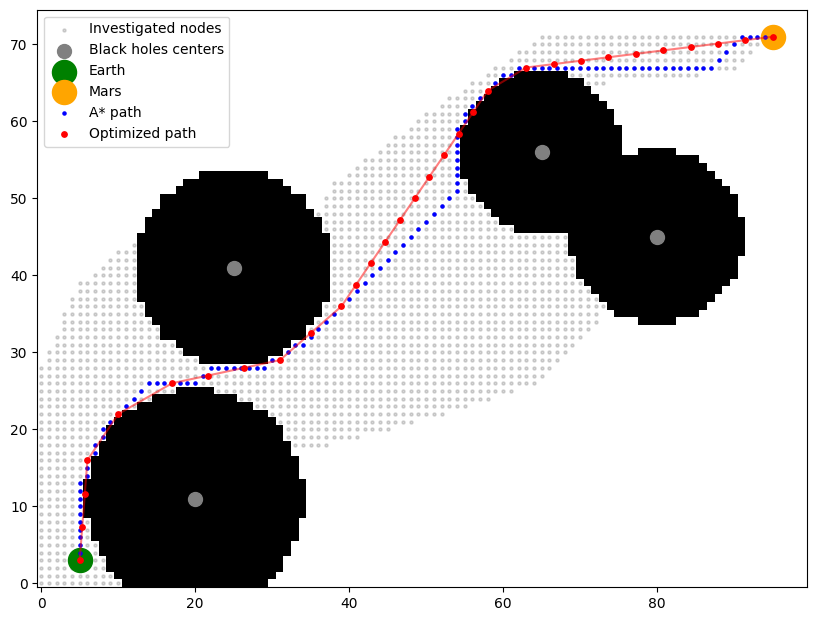

In [15]:
plt.figure(figsize=(10,7.5))
plt.imshow(occ.transpose(), cmap='Greys', origin='lower')
plt.scatter([x[0] for x in closed], [x[1] for x in closed], c='grey',s=5, alpha=0.3)
plt.scatter([x[0] for x in black_holes_centers], [x[1] for x in black_holes_centers], c='grey',s=100)
plt.scatter(earth[0],earth[1], c='green',s=300)
plt.scatter(goal[0],goal[1], c='orange',s=300)
plt.scatter([x[0] for x in path], [x[1] for x in path],color = 'b',s=5)
plt.scatter([x[0] for x in opti_path], [x[1] for x in opti_path], c='r',s=15)
plt.plot([x[0] for x in opti_path], [x[1] for x in opti_path], c='r', alpha=0.5)
plt.legend(['Investigated nodes','Black holes centers', 'Earth', 'Mars' , 'A* path', 'Optimized path'])
plt.show()

## 4. Local Navigation <a class="anchor" id="local_navigation"></a>

Thymio needs to avoid obstacles, in this case asteroids, as it travels through space. To do this, we call the function local_avoidance() that allows Thymio to avoid the obstacle and continue it way to Mars.

Sources:

Solutions Week 3 - Artificial neural networks.ipynb



### 4.1. Local Navigation Function <a class="anchor" id="local_navigation_function"></a>

#### Input:
- Current motors speed, horizotnal proximity sensors values

This function will take the current value of the motors and, depending on the weights and values of the various sensors, adjust the values of the motors so that it dodges the obstacle.

#### Output:
- new motors values (new motor_left_target,motor_right_target) allowing to avoid the obstacle
- To avoid the robot to be blocked when it faces a front obstacle we adjust the weight so that it has a higher tendency to go on left.

#### Call:
- At each step of global navigation

In reality, when the global path function is called, it generates a path with segments. It then calls the drive() function, which splits the segment into 10 smaller segments. This is where we call the get_prox() function to compare the value of the proximity sensors with our WALL_THRESHOLD. This method gives the robot better detection on its path between two points on the layout.

#### Limitations:
The first limitation of this implementation lies in the call. Dividing the distance between 2 points into smaller distances partially solves the problem, because if an obstacle appears between these two smaller distances, the previous problem reappears. However, we don't do this when we're turning, which may mean that the robot doesn't detect obstacles properly when repositioning itself. 
A better approach would have been to use two different threads in parallel. Because what can happen is that the robot oscillates between the global_path() and local_navigation() functions and jerks. 

### 4.2. Keys parameters <a class="anchor" id="key_parameters"></a>

| Name | Meaning | Type (Unit) | Global|
|-----------|-----------|-----------|-----------|
|max_allowed_speed|Limit the speed outpout of the motor in local_navigation|int|no|
|mem_sensor|Store the values of the 5 front sensors get by get_prox()|int|no|
|sensor_scale|Rescale the output value of the sensors|int|no|
|WALL_THRESHOLD|Threshold to determined when there is an obsctacle|int|yes||
|ROBOT_SPEED|Current robot speed|int|yes|

## 5. Motion control <a class="anchor" id="motion_control"></a>



### 5.1. Drive functions <a class="anchor" id="drive"></a>

The drive function works by sleeping for the amount of s required to drive a distance of X [cm]. We started off by calibrating the robot: the Thymio used for our project drives 6cm in 1s. This gives us a speed_drive = 6 cm/s for a motor speed of 150. The time the robot needs to sleep to drive a distance is: dist/speed_drive = [s]

The driving is split into two functions: one that simply sets the speed of the motors to the desired speed, and another one that sets calculates the time the robot has to drive and makes it drive for that amount of seconds using time.sleep() [s].

In [16]:
@tdmclient.notebook.sync_var
# drive straight with "speed" (motor speed)
def motors_drive(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

# drive "dist" [cm]
def drive(dist=10):
    global WALL_THRESHOLD, ROBOT_SPEED
    motors_drive(ROBOT_SPEED,ROBOT_SPEED) #test with lower speed value
    for i in range(10):
        time.sleep((dist/(2*3))/10) 
        if max(get_prox()) > WALL_THRESHOLD:
            print("obstacle detected")
            local_navigation()
            break
    motors_drive(0,0)

### 5.2. Turn functions <a class="anchor" id="turn"></a>

The turn function works in a very similar way: there is one function that makes the robot turn in a circle on the spot - clockwise and anticlockwise.

Note that if the angle is positive, the robot turns clockwise. The speed of turning for a motor speed of 100 is speed_turn = 360°/9s.

The Thymio needs to sleep for degrees/speed_turn.

In [17]:
# UPDATE THIS
@tdmclient.notebook.sync_var 
# turn in a circle with "speed" (motor speed)
def motors_turn(speed=100):
    global motor_left_target, motor_right_target
    motor_left_target = -speed
    motor_right_target = speed
    
@tdmclient.notebook.sync_var 
def motors_turn_right(speed=100):
    global motor_left_target, motor_right_target
    motor_left_target = speed
    motor_right_target = -speed

# turn "angle" [degrees] anticlockwise
def turn_degrees(angle):
    if angle < 0:
        motors_turn()
        time.sleep(abs(angle)*9/360) # 18s for 360° turn with motor speed = 100
        motors_turn(speed=0)
    else:
        motors_turn_right()
        time.sleep(abs(angle)*9/360)
        motors_turn_right(speed=0)

## 6. Filtering <a class="anchor" id="filtering"></a>

In [ ]:
# Imports
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sn 

# Constants
P_HIT = 0.8 # Probability that the robot moved to the correct position (or "pixel")
P_MISS = 0.2/8 # Probability that the robot moved to one of the 8 neighbouring "pixel"


### 6.1. Introduction to the Markov Filter <a class="anchor" id="markov_filter"></a>

To get a better accuracy of the position of the robot, a Markov Localisation Filter is used. It is based on the Bayes Filter. The Markov process consists of a sequence of states, where each future state only depends on the current state. Markov Localization is particularly useful in scenarios where the environment is partially observable, and there is uncertainty in both the robot's actions and sensor measurements.

The filtering is done after each segment of the global path that the robot has driven

This is the header of the Markov function:

markov(x_robot,y_robot,x_CV,y_CV,confindence_CV,first_step)
Input:

belief position of the robot based on the global path (x_robot,y_robot)
position of the robot given by CV (x_CV,y_CV)
confidence of the robot's position given by CV
first_step: True if it the robot has just driven the first segment of the global path, False otherwise
Output:

more accurate position of the robot (x,y)

Source: "MOBILE ROBOTS 7/8 - Uncertainties" from Prof. Mondada of the class "Basics of Mobile Robotics", MICRO-452, EPFL.

### 6.2. Implementation of the Markov Filter <a class="anchor" id="application_filter"></a>

The algorithm consists of the following steps: 0) Initialize the maps

Belief state
Sensor update
Motion update
Calculation step
Recursive estimation
Decisions taken:

The size of the camera frame is: 480x640 - hight x width. We chose the map to have the size of 75 x 100 which has the same ratio as the camera frame.
We assume that the motion control of the robot is accurate 80% of the time and that the robot is otherwise going to be on a neighbouring pixel with a probability of 0.8/8 (there are 8 niehgbouring pixels).

#### 6.2.1. Initialisation of the map <a class="anchor" id="map_initialisation"></a>

This step is done once at the start of the program. To compute the Markov filter, we need three maps of the same size (75x100) "pixels". Please note that "pixels" refers to the individual squares on the map, not the camera pixels. The base map (map) is inisialized with a base probability of 1/(width*height) of the map. The map_estimate_robot and the map_estimate_CV containing the belief and measured position of the robot respecitively, are empty.

In [2]:
# map: each square has the prob = 1/(height * length)
# map_estimate_robot: empty map with size height x length
# map_estimate_CV: empty map with size height x length
def initialize_maps(length,height):
    global map, map_estimate_robot, map_estimate_CV
    
    # initialize map
    start_prob = 1/(length*height)
    map = np.empty((length,height), float)
    map.fill(start_prob)
    #display_heatmap(map)

    # initialize map_estimate_robot
    map_estimate_robot = np.empty((length,height), float)
    map_estimate_robot.fill(0.0)

    # initialize map_estimate_CV
    map_estimate_CV = np.empty((length,height), float)
    map_estimate_CV.fill(0)

    print(map)

#### 6.2.2. State belief <a class="anchor" id="state_belief"></a>

In our case, the belief state corresponds to the position the robot is supposed to have after having driven a segment according to the global path. It is therefore simply equal to the current step of the global path. The probability that the robot is in the "pixel" it is supposed to be in is 0.8. The probability that it's in one of the surrounding pixels is 0.8/8 (there are 8 surrounding pixels).




In [3]:
def estimate_robot(x,y):
    global map_estimate_robot   
    
    # reset map to 0.0
    map_estimate_robot.fill(0.0)

    # the robot has a probability of P_HIT to be on the "pixel" is should be on
    map_estimate_robot[x][y] = P_HIT
    # the robot has a probability of P_MISS to be on a neighbouring "pixel"
    neighbouring_pixels(x,y,P_MISS,map_estimate_robot)




# Function to update the probabilities of the neighboring pixels
def neighbouring_pixels(x,y,prob,any_map):
    global map_estimate_robot
    
    length,height = np.shape(any_map)

    # the if-statements make sure that we stay within any_map of dimensions length x height

    if (x-1 >= 0):    
        # Left row of neighbors
        if (y-1 >= 0):
            any_map[x-1][y-1] = prob
        any_map[x-1][y] = prob
        if (y+1 <= (height-1)):
            any_map[x-1][y+1] = prob

        # Middle row of neighbors
        if (y-1 >= 0):
            any_map[x][y-1] = prob

        any_map[x][y+1] = prob

    if (x+1 <= (length-1)):
        # Right row of neighbors
        if (y-1 >= 0):
            any_map[x+1][y-1] = prob
        any_map[x+1][y] = prob
        if (y+1 <= (height-1)):
            any_map[x+1][y+1] = prob

#### 6.2.3. Sensor update <a class="anchor" id="sensor_update"></a>

The CV gives the position of the robot and also a confidence value. The given position has a confindence of that confidence value, the surrounding "pixels" have a probability of (1-confidence)/8 (there are 8 surrounding pixels).

In [4]:
def estimate_CV(x,y,confidence_CV):
    # reset map to 0
    map_estimate_CV.fill(0)

    # add prob
    MEAS_P_HIT = confidence_CV
    MEAS_P_MISS = (1-confidence_CV)/8

    # confidence that the CV gave the correct position
    map_estimate_CV[x][y] = MEAS_P_HIT
    # probability that the CV thinks that the robot is on a neighbouring "pixel"
    neighbouring_pixels(x,y,MEAS_P_MISS,map_estimate_CV)
    

#### 6.2.4. Motion update and Calculation step <a class="anchor" id="calculation_step"></a>

There is no need for a motion update as the global path is simply recalculated after each segment of the global path based on the position given by the filter.

The map, map_estimate_CV, and map_estimate_robot are multiplied and subsequently normalized so that the sum of all the elements in the map is equal to 1.

The function filtered_pos_robot() finds the indexes of the "pixel" in the map that has the highest probability. If there are multiple pixels that have the same probability, the function multiple_highest_prob_with_same_value(pos_robot,indices) return the "pixel" that is the closest to the belief position of the robot

In [8]:
# Function to multiply probability maps and update the global map variable
def multiply_maps():
    global map, map_estimate_CV, map_estimate_robot

    # Multiply the probability maps of computer vision (CV) and robot belief position
    temp = np.multiply(map_estimate_CV,map_estimate_robot)
    
    # if the estimated position of the robot and by CV are too far apart, or the last position of the robot and its position now, the whole map after multiplication is = 0
    # in this case, set map = map_estimate_robot as it is less likely that the position measured by the robot is off by a lot than the CV
    
    if (not np.any(temp)):
        # If the multiplication results in all zeros, retain the current map value
        map = map
    else:
         # Update map by multiplying it with the temporary result
        map = np.multiply(map,temp)
    if (not np.any(map)):
         # If the resulting map is all zeros, update map to map_estimate_CV
        map = map_estimate_CV # IS THIS NECESSARY ????????



# Function to normalize the values in map such that the sum of all elements is 1
def normalize_map():
    global map
  
    # Calculate the sum of all values in the map array
    sum = np.sum(map)
     # Divide each element in the map array by the sum to normalize the values
    map = np.divide(map,sum)
    

# if multiple "pixels" have the same probability, we choose the one that is closest to the position of the robot
def multiple_highest_prob_with_same_value(pos_robot,indices):

    # save estimated position of robot, estimated by itself
    pos_robot_x = pos_robot[0].item()
    pos_robot_y = pos_robot[1].item()
    point = np.array([pos_robot_x, pos_robot_y])

    # put values of pos with the same highest prob in a table, table[0] -> x, table[1] -> 1
    table = np.array(indices).tolist()

    # Transpose the table array
    table_array = np.array(table).T

    # Calculate Euclidean distances
    distances = np.linalg.norm(table_array - point, axis=1)

    # Find the index of the minimum distance
    closest_index = np.argmin(distances)
    X_ROBOT = table[0][closest_index]
    Y_ROBOT = table[1][closest_index]

    return X_ROBOT,Y_ROBOT



def filtered_pos_robot():
    # Find indices where the maximum value occurs in map
    indices = np.where(map == map.max())
    # Find indices where the maximum value occurs in map_estimate_robot
    pos_robot = np.where(map_estimate_robot == map_estimate_robot.max())
    
    # Check if there is a single pair of coordinates in indices
    if (np.size(indices)==2): 
        # If there is only one maximum, assign X_ROBOT and Y_ROBOT directly
        X_ROBOT = indices[0].item()
        Y_ROBOT = indices[1].item()
    else:
        # If there are multiple maxima, use a function to resolve the conflict
        X_ROBOT, Y_ROBOT = multiple_highest_prob_with_same_value(pos_robot,indices)
    
    # Return the X and Y coordinates of the robot
    return X_ROBOT,Y_ROBOT

#### 6.2.5. Heatmap plot <a class="anchor" id="heatmap"></a>

Plotting the heatmap: This function plots a heatmap using the seaborn library,. This helps visualize the probabilities of the different "pixels".



In [10]:
# displays the heatmap of data_to_display
def display_heatmap(data_to_display):
    displayed_map = sn.heatmap(data = data_to_display, annot=False, linewidth=.5, vmin=0, vmax=1.0) 
    displayed_map.invert_yaxis()

#### 6.2.6.Markov function <a class="anchor" id="m_function"></a>

The function markov(x_robot,y_robot,x_CV,y_CV,confindence_CV)
Finally, this is the function that runs the Markov filter.

As (x_CV,y_CV) is a float, it needs to be converted to an integer before being used by the Markov filter. We chose a 64bit integer and to round down (x_CV,y_CV)

In [12]:
def markov(x_robot,y_robot,x_CV,y_CV,confindence_CV):
    # Initialize local variables
    x_filtered_pos_robot = 0
    y_filtered_pos_robot = 0
    # take integer value (rounded down)
    x_robot = np.int64(x_robot)
    y_robot = np.int64(y_robot)
    x_CV = np.int64(x_CV)
    y_CV = np.int64(y_CV)
    
    # Running the Markov Filter
    estimate_robot(x_robot,y_robot)
    estimate_CV(x_CV,y_CV,confindence_CV)
    multiply_maps()
    normalize_map()
    x_filtered_pos_robot, y_filtered_pos_robot = filtered_pos_robot()

    if ((abs(x_CV-x_robot) >= 3) or (abs(x_CV-x_robot) >= 3) or first_step):
        print("in special case")
        x_filtered_pos_robot = x_CV
        y_filtered_pos_robot = y_CV
        #update map
        map[x_robot][y_robot] = 0.8
        neighbouring_pixels(x_robot,y_robot,0.025,map)


    return x_filtered_pos_robot, y_filtered_pos_robot

The maps below illustrate what the probability distribution looks like for a certain belief position of the robot.

Ntoe that in the heatmap, the vertical axis is the x-axis and the horizontal axis is the y-axis.


In [ ]:
# to make it easier to see, this map has a size of 10x10 "pixels"
# please note that the surrounding pixels have a probability of 0.025 which has the color dark blue and is therefore not visible
initialize_maps(10,10)
estimate_robot(5,6)

# printed map containing the belief position of the robot
print(map_estimate_robot)
# heatmap 
display_heatmap(map_estimate_robot)



The following code is an example of the Markov filter used in this project.

In [ ]:
# on the first iteration of the Markov filter, the maps have to be initialized
initialize_maps(10,10)

# belief position of robot
x_robot = 5
y_robot = 6
# CV
x_CV = 4
y_CV = 5
confid_CV = 0.82
# Markov Filter
x_filtered_robot, y_filtered_robot = markov(x_robot,y_robot,x_CV,y_CV,confid_CV)

# visualization
print("filtered value of the x position of the robot: ", x_filtered_robot)
print("filtered value of the y position of the robot: ", y_filtered_robot)
display_heatmap(map)

If there is a big difference between the belief position of the robot and the position given by CV, we choose the filtered position to be the position given by CV. This also allows us to handle kidnapping.

In [ ]:
# belief position of robot
x_robot = 1
y_robot = 2
# CV
x_CV = 3.4442345
y_CV = 2
confid_CV = 0.75
# Markov Filter
x_filtered_robot, y_filtered_robot = markov(x_robot,y_robot,x_CV,y_CV,confid_CV)

# visualization
print("filtered value of the x position of the robot: ", x_filtered_robot)
print("filtered value of the y position of the robot: ", y_filtered_robot)
display_heatmap(map)

### 6.3. Limitations of the Markov Filter <a class="anchor" id="problems"></a>

One of the limitations of this implementation of the Marokv filter is that there are a lot of "pixels" (75 x  100), but for the position given by the robot or the CV, only a square of 9 "pixels" is looked at. This means that if the position given by the robot and the one given by CV differ by more than 3 "pixels", the multiplication of the maps results in an empty map. In such a case we simply take the position of the 


A possible solution could be to increase the size of a "pixel". That, however, would lead to a loss in precision.

Since the float coordinate values given by CV are rounded down to an integer, we loose some precision. This is acceptable as the mouvement of the robot is not that precise and because there is anyways a light distortion of the map caused by the camera.







## 7. Main code <a class="anchor" id="main_code"></a>


### 7.1. Packages and Functions importation <a class="anchor" id="packages_functions_importation"></a>

In [20]:
import math 
import numpy as np
import tdmclient.notebook

import cv2
from ultralytics import YOLO

from CV_function import *
from path_object import *
from Markov_Filter import *

### 7.2. Initialize Thymio functions <a class="anchor" id="Thymio_functions"></a>

In [ ]:
try:
    await tdmclient.notebook.stop()
except:
    pass
await tdmclient.notebook.start()

WALL_THRESHOLD = 500
ROBOT_SPEED = 150

@tdmclient.notebook.sync_var
def get_prox():
    global prox_horizontal
    return prox_horizontal

def local_navigation():
    global WALL_THRESHOLD, ROBOT_SPEED
    max_allowed_speed = 150
    set_var(leds_top = [32, 0, 0])
    while max(get_prox())>WALL_THRESHOLD:
        weight_left = [25,  15, -20, -15, -25]
        weight_right = [-25, -15, -15,  15,  25]
    
        # Scale factors for sensors and constant factor
        sensor_scale = 500
    
        mem_sensor = [0,0,0,0,0]
        prox_horizontal = get_prox()
        
        for i in range(len(mem_sensor)):
            # Get and scale inputs
            mem_sensor[i] = prox_horizontal[i] // sensor_scale
    
        y = [ROBOT_SPEED,ROBOT_SPEED]   
        
        for i in range(len(mem_sensor)):   
            # Compute outputs of neurons and set motor powers
            y[0] = y[0] + mem_sensor[i] * weight_left[i]
            y[1] = y[1] + mem_sensor[i] * weight_right[i]
    
        # Set motor powers
        set_var(motor_left_target = min(y[0],max_allowed_speed))
        set_var(motor_right_target = min(y[1],max_allowed_speed))
        time.sleep(0.2)
    set_var(leds_top = [0, 0, 32])

    return 0


@tdmclient.notebook.sync_var
# drive straight with "speed" (motor speed)
def motors_drive(l_speed=500, r_speed=500):
    global motor_left_target, motor_right_target
    
    motor_left_target = l_speed
    motor_right_target = r_speed

# drive "dist" [cm]
def drive(dist=10):
    global WALL_THRESHOLD, ROBOT_SPEED
    motors_drive(ROBOT_SPEED,ROBOT_SPEED) #test with lower speed value
    for i in range(10):
        time.sleep((dist/(2*3))/10) #motor speed = 50 equals 2.5cm/s -> calculates how many s you have to drive to cover a distance "dist" [cm]
        if max(get_prox()) > WALL_THRESHOLD:
            print("obstacle detected")
            local_navigation()
            break
    motors_drive(0,0)


@tdmclient.notebook.sync_var 
# turn in a circle with "speed" (motor speed)
def motors_turn(speed=100):
    global motor_left_target, motor_right_target
    motor_left_target = -speed
    motor_right_target = speed
    
@tdmclient.notebook.sync_var 
def motors_turn_right(speed=100):
    global motor_left_target, motor_right_target
    motor_left_target = speed
    motor_right_target = -speed

# turn "angle" [degrees] anticlockwise
def turn_degrees(angle):
    if angle < 0:
        motors_turn()
        time.sleep(abs(angle)*9/360) # 18s for 360° turn with motor speed = 100
        motors_turn(speed=0)
    else:
        motors_turn_right()
        time.sleep(abs(angle)*9/360)
        motors_turn_right(speed=0)

# turn "angle" (2. row of Astar_moves) then drive "dist" (1.row of Astar_moves)
def follow_path(dist,angle):
    turn_degrees(angle)
    drive(dist)
    
#used to initialize the follow robot command
def follow_path_init(path, current_angle,scale_factor):
    Ang = get_angle(path[0],path[1])
    Ang = Ang  - current_angle
    if abs(Ang) > 180:
                    if Ang > 0:
                        Ang = Ang-360
                    else:
                        Ang = Ang+360
    dist = get_distance(path[0],path[1])
    current_angle = Ang + current_angle
    follow_path(dist*scale_factor,-Ang)
    return current_angle

### 7.3. Main loop <a class="anchor" id="main_loop"></a>

In [ ]:
#Initialize Global path object
global_nav = Global_nav()

#initialize markov filter map 
map_max_x = 100
map_max_y = 75
initialize_maps(map_max_x,map_max_y)


#Set current angle to 0
current_angle = 0
#robot LED in driving mode
set_var(leds_top = [0, 0, 32])

i = 0
#Initialize camera
cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID') 
output_ = cv2.VideoWriter('output.avi', fourcc, frames_per_second, (frame_height, frame_width)) 
while cap.isOpened():
    
    #image localization
    success, frame = cap.read()
    if  success:
        ## Computer vision detection
        array_box_dim_tot, annotated_frame = detection(frame)
        
        sorted_object = sorted(array_box_dim_tot, key=lambda x: order.get(x[0]))
        #break when q is pressed
        key = cv2.waitKey(1) & 0xFF 
        if key == ord('c'):  
            break  
    else:
        print("Unable to load the camera pic")
        break

    #fixing output from camera, use last output if no object is detected
    sorted_object = fix_output(sorted_object,sorted_object_last)
    

    #blind mode if no object is detected. Follow last calculated path with position and angle update from robot itself
    if sorted_object == False: 
        start = opti_path[1] 
        opti_path = opti_path[1:]
        if len(opti_path) == 1:
            print("Reached goal")
            set_var(leds_top = [0, 32, 0])
            break
        current_angle = follow_path_init(opti_path,current_angle,scale_factor)
        last_robot_pos = list(start)
        #print frame
        annotated_frame = frame
        cv2.imshow("frame", annotated_frame)
        continue #skip rest of loop to try to find object in next frame

    #save last output
    sorted_object_last = sorted_object

    #change format of pic output 
    start, goal, earth, robot_radius, earth_radius, black_holes_centers, black_holes_radiuss,scale_factor = global_nav.convert_OPENCV_tovalues(sorted_object)
    #if distance between robot and mars is less than 5 stop 
    if get_distance(start,goal) < 4:
        print("Reached goal")
        set_var(leds_top = [0, 32, 0])
        break
    
    #create map for gloabl navigation
    occ, _,_=  global_nav.create_map( goal = goal ,black_holes_centers = black_holes_centers,black_holes_radiuss=black_holes_radiuss)

    #use markov filter to update position 
    if i>0:
        start = markov(opti_path[1][0],opti_path[1][1],start[0],start[1],sorted_object[0][2],i==0)        

    #return path. Use the opti_path! 
    opti_path, _, _, _ = global_nav.get_path_straight(start=start,goal=goal)

    #convert optipath to format used by camera
    scaled_coords = convert_coordinates_2d_list(opti_path)

    #annotate frame
    if i>0:
        annotation(annotated_frame, scaled_coords)
    cv2.imshow("frame", annotated_frame)
    output_.write(annotated_frame)
    
    #update current angle. Take the average of the calculated from image and robot motion
    if i != 0: 
        if list(start) != last_robot_pos:
            current_angle = update_angle(last_robot_pos,start,current_angle)


    #follow first two points in path
    current_angle = follow_path_init(opti_path,current_angle,scale_factor)

    #save last robot position
    last_robot_pos = list(start)

    i+=1

#print last frame and save video
success, frame = cap.read()
array_box_dim_tot, annotated_frame = detection(frame)
cv2.imshow("frame", annotated_frame)
cv2.startWindowThread()
cap.release()
output_.release()
cv2.destroyAllWindows()

## 8. Videos Demonstration <a class="anchor" id="videos_demonstration"></a>

### 8.1. Demonstration without kidnapping  <a class="anchor" id="videos_demonstration_without"></a>
<div style="text-align: center;">
    <video width="640" height="480" 
           src="./robot_demo.mp4"  
           controls>
    </video>
</div>

### 8.2. Demonstration with kidnapping <a class="anchor" id="videos_demonstration_with"></a>

<div style="text-align: center;">
    <video width="640" height="480" 
           src="./robot_demo_v1.mp4"  
           controls>
    </video>
</div>

### 9. Conclusion <a class="anchor" id="conclusion"></a>

In space a robust system is important. That is why we chose to go with a system that updates all postitions and paths in each step. While this is not a fast method, since posistions and global path has to be recomputated, the method allows all part of the system to move and still have the space ship (robot) find its way to Mars. Doing the navigation in steps meant that we could not achive a smooth trajectory of the robot. However, this method did prove to make the whole system very robust. We can move the camera, move the robot, and move obstacles and still have the space ship land on Mars.

### 10. References <a class="anchor" id="references"></a>

#### 10.0. General <a class="anchor" id="rg_references"></a>

- https://chat.openai.com/
- https://github.com/hibetterheyj/Thymio_Vision_Guided_Navigation/blob/master/BMR_Final_Project.ipynb 

#### 10.1. Computer Vision <a class="anchor" id="cv_references"></a>


- https://blog.roboflow.com/whats-new-in-yolov8/
- https://en.wikipedia.org/wiki/Convolutional_neural_network


#### 10.2. Global Path <a class="anchor" id="gb_references"></a>

- https://en.wikipedia.org/wiki/A*_search_algorithm 

#### 10.3. Local Navigation <a class="anchor" id="ln_references"></a>

- Solutions Week 3 - Artificial neural networks.ipynb


#### 10.4. Filtering <a class="anchor" id="f_references"></a>

- "MOBILE ROBOTS 7/8 - Uncertainties" from Prof. Mondada of the class "Basics of Mobile Robotics", MICRO-452, EPFL.